In [2]:
import pickle

import pandas as pd

df = pd.read_json(r"D:\Downloads\Datasets\news_dataset.json")
df.head()

,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [3]:
df.isna().sum()

text        0
category    0
dtype: int64

In [4]:
df[df.duplicated()]

,text,category
4466,How Can Businesses Build Trust? Putting in pla...,BUSINESS
5172,Ferguson Police Officer Shot,CRIME
7259,9 Terrifying American Murder Houses,CRIME
9792,10 Most Hated Companies In America To be truly...,BUSINESS
12268,Two Victims Shot On Texas Southern University ...,CRIME
12410,Dallas Shooting Suspect Confirmed Dead: Police,CRIME


In [5]:
df = df[~df.duplicated()]
df[df.duplicated()]

,text,category


In [6]:
df.category.value_counts()

category
BUSINESS    4252
SPORTS      4167
CRIME       2889
SCIENCE     1381
Name: count, dtype: int64

In [7]:
# Dataset is imbalanaced :( . Needs working.

In [8]:
df['cat_numerical'] = df['category'].replace({"BUSINESS":0,"SPORTS":1,"CRIME":2,"SCIENCE":3})
df.head()

,text,category,cat_numerical
0,Watching Schrödinger's Cat Die University of C...,SCIENCE,3
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE,3
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS,0
3,These Roads Could Recharge Your Electric Car A...,BUSINESS,0
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME,2


In [9]:
df.category.value_counts(), df.cat_numerical.value_counts()

(category
 BUSINESS    4252
 SPORTS      4167
 CRIME       2889
 SCIENCE     1381
 Name: count, dtype: int64,
 cat_numerical
 0    4252
 1    4167
 2    2889
 3    1381
 Name: count, dtype: int64)

<h1 style="color: green"> Balancing Dataset(SMOTE) </h1>

In [10]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', random_state=1)

<h2 style="color: purple"> Defining a function to do Lemmatization and dropping stop words </h2>

In [11]:
import spacy
nlp = spacy.load("en_core_web_sm")

def processing(text):
    doc = nlp(text.lower())
    lst_no_stops_and_punct = []
    for token in doc:
        if token.is_punct or token.is_stop:
            continue
        lst_no_stops_and_punct.append(token.lemma_)
    return " ".join(lst_no_stops_and_punct)

In [12]:
processing("he ate a burger last day")

'eat burger day'

In [13]:
df['processesed_text'] = df.text.apply(processing)

In [14]:
df.sample(5)

,text,category,cat_numerical,processesed_text
4596,"If You Trust Big Corporations, Don’t Read This...",BUSINESS,0,trust big corporation read president trump rec...
5622,An Afternoon With Peter Lynch As part of the C...,BUSINESS,0,afternoon peter lynch catholic speakers series...
5975,Why Won't Frontier Fix My Landline? When the p...,BUSINESS,0,will frontier fix landline phone company chery...
8622,New Ad Proves D.C. Football Can Survive Withou...,SPORTS,1,new ad prove d.c football survive redskin onli...
6662,Dallas Police Chief Who Guided Force During Sn...,CRIME,2,dallas police chief guide force sniper attack ...


<h2 style="color: purple">Creating X and y </h2>

In [15]:
X = df.drop(['category','cat_numerical','text'], axis=1)
X.head()

,processesed_text
0,watch schrödinger cat die university californi...
1,watch freaky vortex open flood lake
2,entrepreneur today need big budget start year ...
3,road recharge electric car drive high tech hig...
4,civilian guard fire gun protect recruiting cen...


In [16]:
y = df.cat_numerical
y.head()

0    3
1    3
2    0
3    0
4    2
Name: cat_numerical, dtype: int64

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.processesed_text,df.cat_numerical, test_size=0.2, stratify=df.cat_numerical, random_state=1)
y_train.value_counts(), y_test.value_counts()

(cat_numerical
 0    3401
 1    3334
 2    2311
 3    1105
 Name: count, dtype: int64,
 cat_numerical
 0    851
 1    833
 2    578
 3    276
 Name: count, dtype: int64)

<h1 style="color: blue"> Training with MultinomialNB </h1>

In [18]:
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB


multinomialnb_pipeline = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('smote', SMOTE(sampling_strategy='auto', random_state=1)),
    ('naive_bayes_nb', MultinomialNB())
])

In [19]:
multinomialnb_pipeline.fit(X_train, y_train)

y_pred = multinomialnb_pipeline.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       851
           1       0.94      0.88      0.91       833
           2       0.87      0.94      0.90       578
           3       0.85      0.83      0.84       276

    accuracy                           0.90      2538
   macro avg       0.89      0.89      0.89      2538
weighted avg       0.90      0.90      0.90      2538


In [20]:
X_train.shape , y_train.shape

((10151,), (10151,))

In [21]:
scores = []
score_nb = multinomialnb_pipeline.score(X_test,y_test)
scores.append(score_nb)

<h1 style="color: blue"> Training with Random Forest </h1>

In [22]:
from sklearn.ensemble import RandomForestClassifier

random_forest_pipeline = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('smote', SMOTE(sampling_strategy='auto', random_state=1)),
    ('random_forest', RandomForestClassifier())
])

In [23]:
random_forest_pipeline.fit(X_train, y_train)

y_pred = random_forest_pipeline.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print("Random Forest:\n")
print(classification_report(y_test, y_pred))

Random Forest:

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       851
           1       0.90      0.82      0.86       833
           2       0.83      0.90      0.86       578
           3       0.86      0.63      0.73       276

    accuracy                           0.85      2538
   macro avg       0.85      0.81      0.83      2538
weighted avg       0.85      0.85      0.84      2538


In [24]:
score_rf = random_forest_pipeline.score(X_test,y_test)
scores.append(score_rf)

<h1 style="color: blue"> Training with KNN </h1>

In [25]:
from sklearn.neighbors import KNeighborsClassifier as KNN

knn_pipeline = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('smote', SMOTE(sampling_strategy='auto', random_state=1)),
    ('knn', KNN(n_neighbors=6))
])

In [26]:
knn_pipeline.fit(X_train, y_train)

y_pred = knn_pipeline.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print('KNN:\n')
print(classification_report(y_test, y_pred))

KNN:

              precision    recall  f1-score   support

           0       0.55      0.60      0.57       851
           1       0.98      0.24      0.39       833
           2       0.73      0.77      0.75       578
           3       0.31      0.90      0.46       276

    accuracy                           0.55      2538
   macro avg       0.64      0.63      0.54      2538
weighted avg       0.71      0.55      0.54      2538


In [27]:
score_knn = knn_pipeline.score(X_test,y_test)
scores.append(score_knn)

In [28]:
scores

[0.9014972419227738, 0.8459416863672183, 0.5543735224586288]

<h1 style="color: red"> Vizualization </h1>

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('fivethirtyeight')

[]

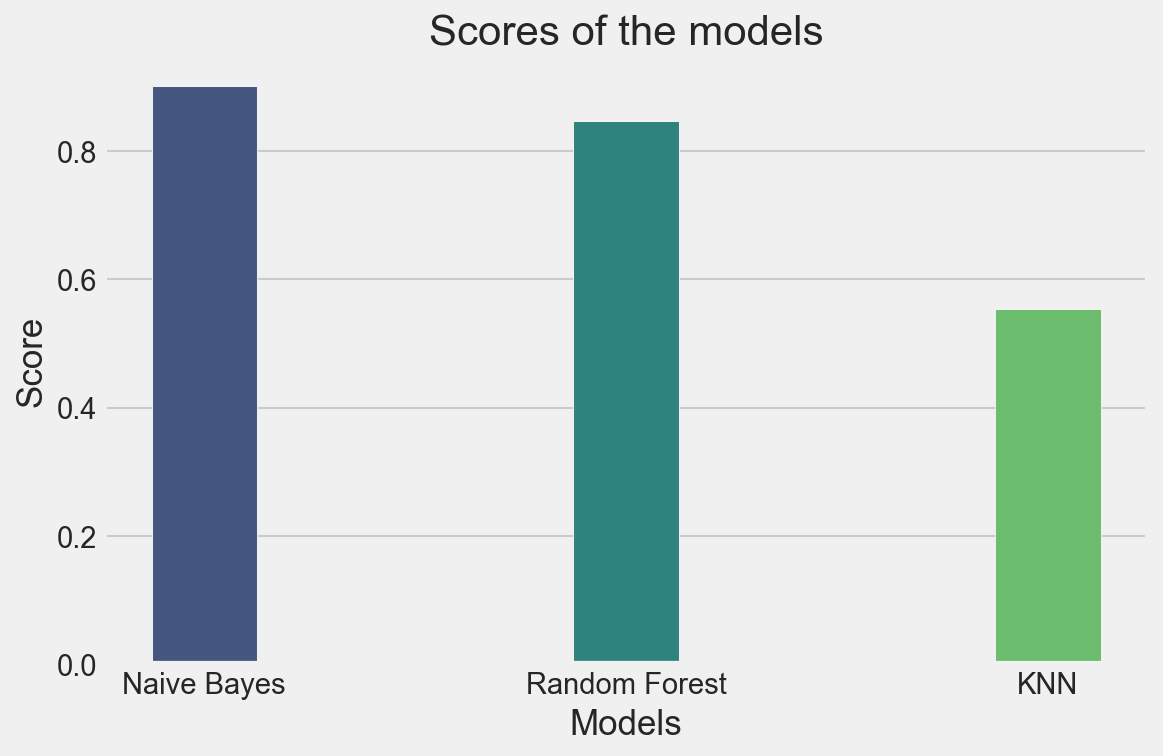

In [30]:
x=['Naive Bayes','Random Forest', 'KNN']

plt.figure(figsize=(8,5), dpi=150)
sns.barplot(x=x, y=scores, palette='viridis', width=0.25, hue=x)
plt.title('Scores of the models')
plt.xlabel('Models')
plt.ylabel("Score")
plt.plot()

In [31]:
class_labels = ["Business", 'Sports', "Crime", 'Science']

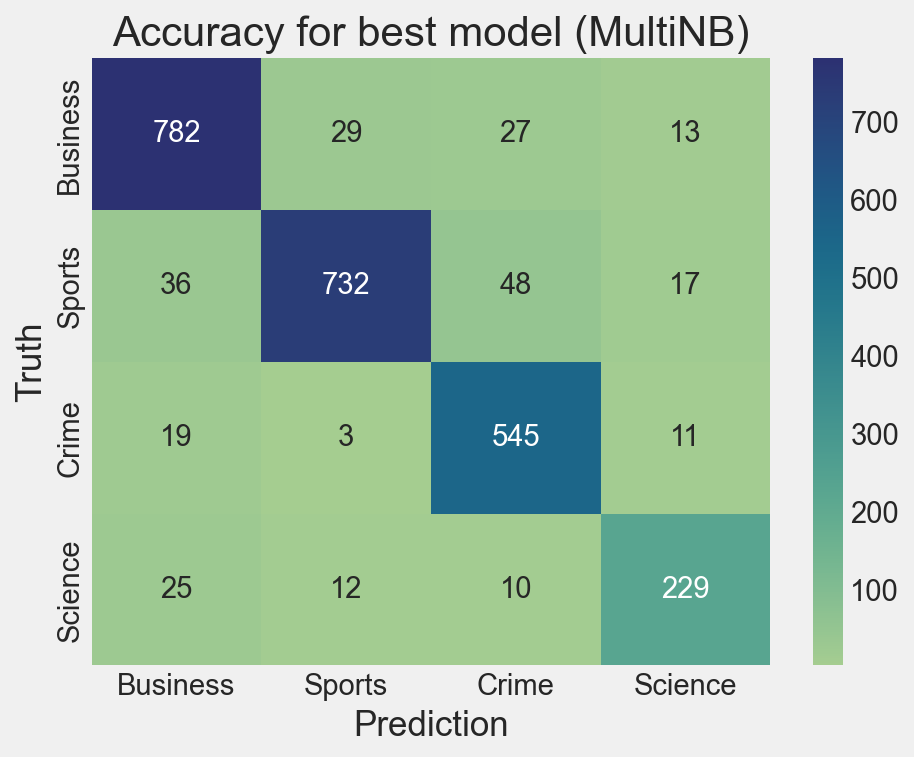

In [32]:
y_hat = multinomialnb_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_hat)

plt.figure(figsize=(6.5,5), dpi=150)
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.title('Accuracy for best model (MultiNB)')
plt.show()

<h1 style="color: magenta"> Exporting pickle file </h1>

In [34]:
import pickle

with open('news_classification.pickle', 'wb') as f:
    pickle.dump(multinomialnb_pipeline, f)